<a href="https://colab.research.google.com/github/pdm17/pdm17/blob/main/project/cifar10/cifar10_DL2_CNN_DataAug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNN model of cifar10 dataset**
- Conv2D + FCN
    * Conv2D : 2차원 합성곱 필터링 + 풀링(Pooling)
    - > 2차원 필터로 영상을 대표하는 특징을 추출
    * FCN : 1차원 완전연결신경망
    - > Conv2D에서 추출된 대표 특징들을 이용하여 FCN으로 최종 학습 완료
    * ## **Data augmentation** : 데이터 증대

***
- ## Traget: **Find the best model** using Data augmentation
***

![cnn_c4f5.png](https://raw.githubusercontent.com/Redwoods/Py/master//pdm2020/my-note/py-tensorflow/images/cnn_c4f5.png)

## Search the best model of C4F5
- callback
    - Early stopping
    - model checkpoint
- Data augmentation

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)

2.9.2


In [2]:
# import TF2 submodules
from tensorflow.keras import layers, models, callbacks

## **데이터 로딩, 정규화**

In [3]:
from keras.datasets import cifar10

(X_train0, y_train0), (X_test0, y_test0) = cifar10.load_data()

# Normalization
X_train, X_test = X_train0/255.0, X_test0/255.0 # 정규화

print("X_train={0}".format(X_train.shape))
print("y_train={0}".format(y_train0.shape)) 
print("X_test={0}".format(X_test.shape))
print("y_test={0}".format(y_test0.shape))

170498071/170498071 [==============================] - 6s 0us/step
X_train=(50000, 32, 32, 3)
y_train=(50000, 1)
X_test=(10000, 32, 32, 3)
y_test=(10000, 1)


In [4]:
# One-Hot-Encoding
# Use function to_categorical() to do One-Hot-Encoding
# tf.keras.utils.to_categorical
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)
y_train.shape,y_test.shape

((50000, 10), (10000, 10))

In [5]:
# y_train0.shape vs. y_train.shape
y_train0.shape, y_train.shape

((50000, 1), (50000, 10))

### Display cifar10 data
- one random image
- 10 representative images

47641


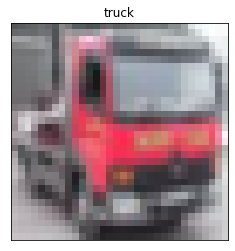

In [6]:
# Code here!
# display one random image from the training set:
class_names =  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

idx = np.random.randint(0, X_train0.shape[0])
print(idx)
image = X_train0[idx]
plt.imshow(image) #, cmap=plt.get_cmap('gray'))
plt.title(class_names[y_train0[idx][0]])
plt.xticks([])
plt.yticks([])
plt.show()

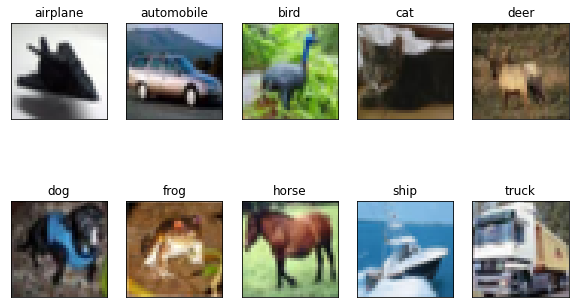

In [7]:
fig = plt.figure(figsize=(10,6))
num0_9 = np.unique(y_train0, return_index=True)[1]
images = X_train[num0_9]
for i in range(10):
    plt.subplot(2, 5, i+1)
    # num0_9 = X_train0[y_train0 == i]
    
    # print(num0_9.shape)
    # plt.imshow(num0_9[0]) 
    plt.imshow(images[i])
    plt.title(class_names[i])
    plt.xticks([])
    plt.yticks([])

## data augmentation

In [8]:
from keras.preprocessing.image import ImageDataGenerator

In [9]:
# data augmentation
# https://github.com/moritzhambach/Image-Augmentation-in-Keras-CIFAR-10-/blob/master/CNN%20with%20Image%20Augmentation%20(CIFAR10).ipynb
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen.fit(X_train)

17753


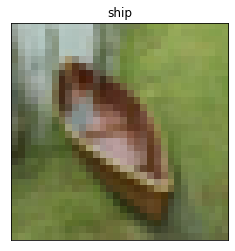

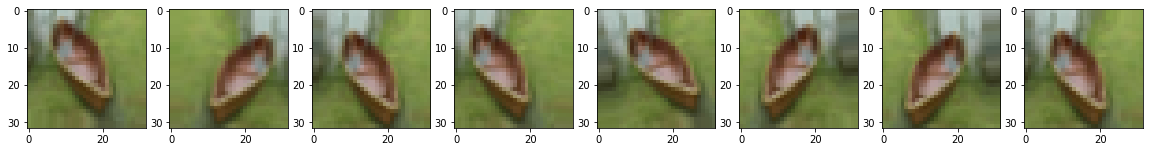

In [10]:
# Show samples of data generation
# Select one sample
idx = np.random.randint(0, X_train.shape[0])
print(idx)
sample = X_train[idx]
sample = np.expand_dims(sample, axis=0)

image = X_train0[idx]
plt.imshow(image) #, cmap=plt.get_cmap('gray'))
plt.title(class_names[y_train0[idx][0]])
plt.xticks([])
plt.yticks([])
plt.show()

obj = datagen.flow(sample, batch_size=1)
fig = plt.figure(figsize=(20,5))

for i in range(8):
	plt.subplot(1,8,i+1)
	image = obj.next()
	plt.imshow(image[0])
plt.show()

(50, 32, 32, 3) (50, 10)


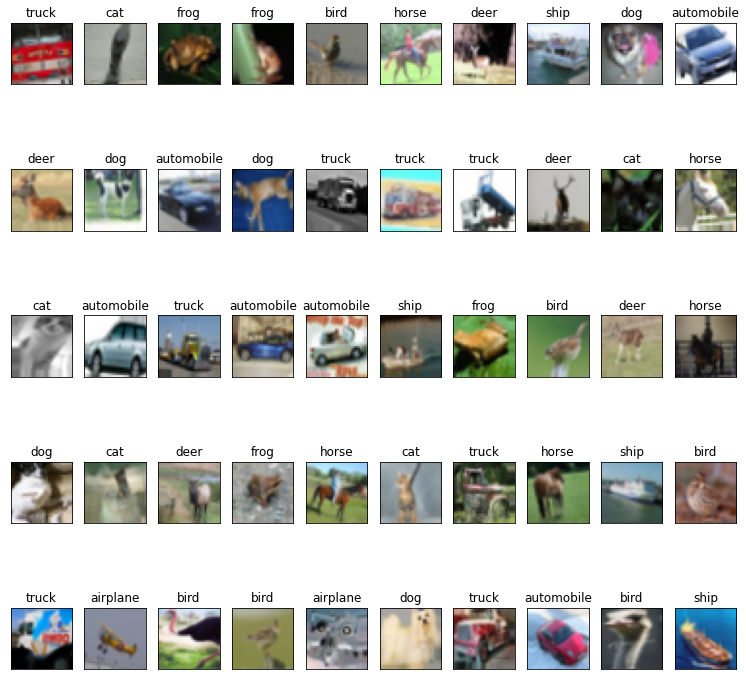

In [11]:
BATCH_SIZE = 50
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=BATCH_SIZE):
    print(X_batch.shape, y_batch.shape)
    # create a grid of 5x10 images
    plt.figure(figsize=(13,13))
    for i in range(BATCH_SIZE):
        plt.subplot(5,10,i+1)
        plt.imshow(X_batch[i]) #, cmap=plt.get_cmap('gray'))
        plt.title(class_names[np.argmax(y_batch[i])])
        plt.xticks([])
        plt.yticks([])
    # show the plot
    plt.show()
    break


# Design CNN

### import models, layers, callbacks
- models: Sequential
- layers: Conv2D, MaxPool2D, Flatten
- callbacks: ModelCheckpoint, EarlyStopping

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, TensorBoard
from keras import regularizers, optimizers

## **CNN4 + FCN5**

In [13]:
c4f5 = keras.models.Sequential([ 
    Conv2D(input_shape=(32,32,3), filters= 64, kernel_size=(3,3),strides=(1,1), padding='same',activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)), 
    Conv2D(filters= 128, kernel_size=(3,3), strides=(1,1), padding='same',activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Conv2D(filters= 256, kernel_size=(3,3), strides=(1,1), padding='same',activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Conv2D(filters= 512, kernel_size=(3,3), strides=(1,1), padding='same',activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Flatten(), 
    keras.layers.Dense(128, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(256, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(512, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(1024, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(10, activation='softmax')
])

c4f5.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

In [19]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 14.6 MB/s 


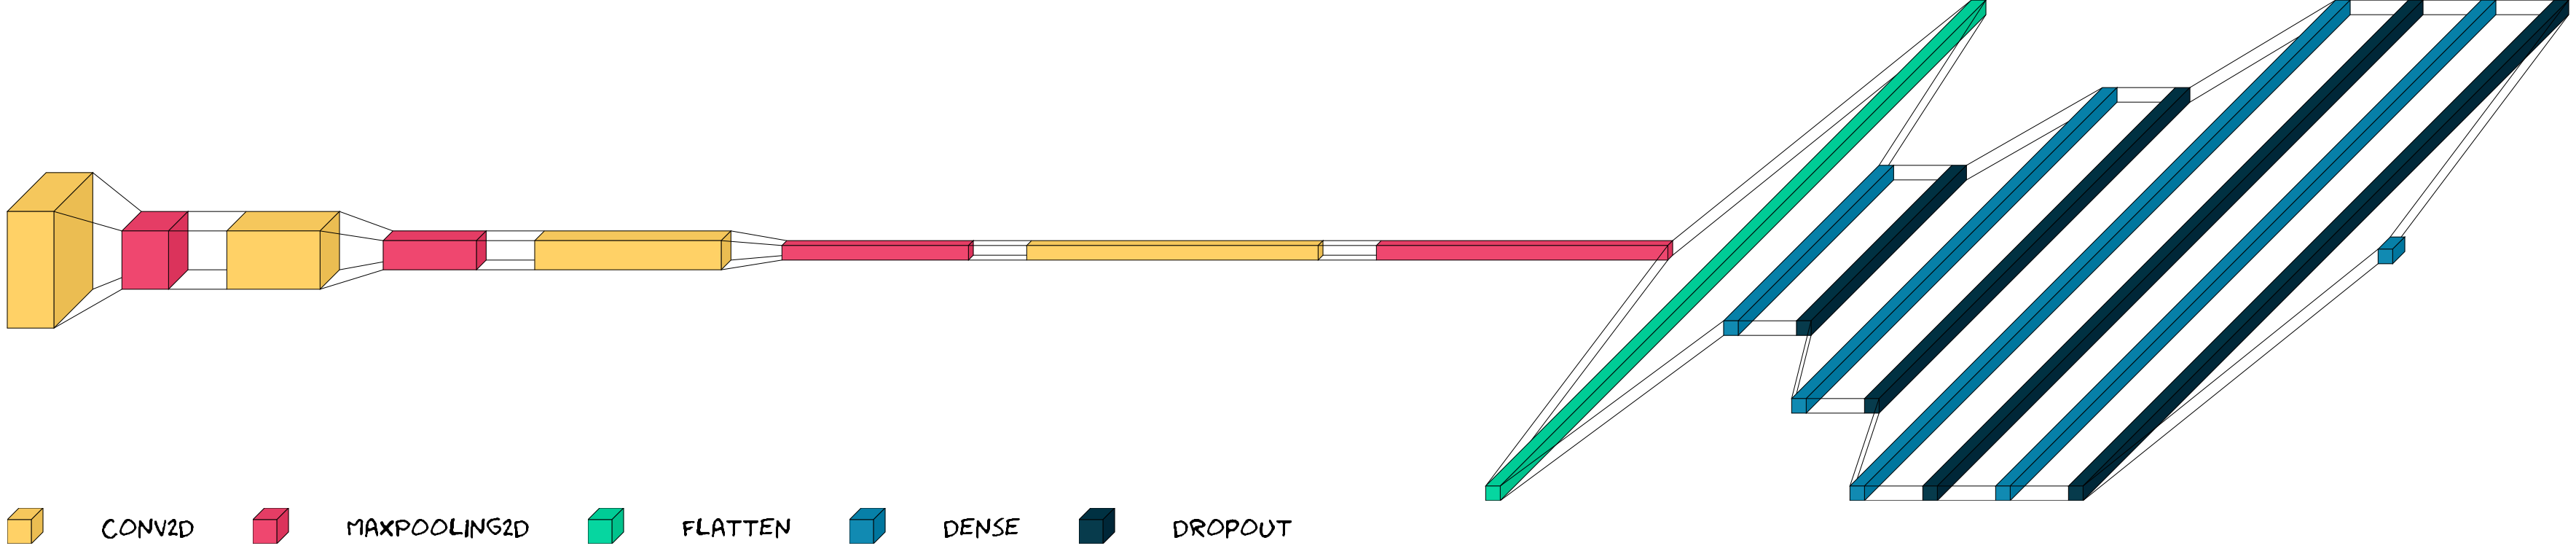

In [20]:
# 모델 구조 시각화 - visualkareas.layered_view()
import visualkeras
from PIL import ImageFont
# font = ImageFont.truetype("arial.ttf", 24) # windows 10/11
font = ImageFont.truetype("Humor-Sans.ttf", 36)  # Linux
visualkeras.layered_view(c4f5, 
                         to_file='./c4f5_daug.png', 
                         legend=True, spacing=80, font=font, 
                         scale_xy=5, scale_z=1, one_dim_orientation='x')

In [21]:
cp_callback = callbacks.ModelCheckpoint(filepath="./cifar10_c4f5_Daug_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)    # patience=10,20,50

In [22]:
#  Training model using augmented data
epochs = 500
BATCH_SIZE = 50
hist = c4f5.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE), # BATCH_SIZE = 50
                 steps_per_epoch=X_train.shape[0]//BATCH_SIZE, 
                 epochs=epochs, verbose=1, 
                 callbacks=[cp_callback, es_callback], 
                 validation_data=(X_test,y_test))    

Epoch 1/500
1000/1000 [==============================] - 43s 34ms/step - loss: 1.7506 - accuracy: 0.3235 - val_loss: 1.4212 - val_accuracy: 0.4815
Epoch 2/500
1000/1000 [==============================] - 31s 31ms/step - loss: 1.3610 - accuracy: 0.5031 - val_loss: 1.0928 - val_accuracy: 0.6138
Epoch 3/500
1000/1000 [==============================] - 32s 32ms/step - loss: 1.1741 - accuracy: 0.5888 - val_loss: 1.0848 - val_accuracy: 0.6239
Epoch 4/500
1000/1000 [==============================] - 31s 31ms/step - loss: 1.0669 - accuracy: 0.6292 - val_loss: 0.9733 - val_accuracy: 0.6648
Epoch 5/500
1000/1000 [==============================] - 32s 32ms/step - loss: 0.9986 - accuracy: 0.6565 - val_loss: 0.9037 - val_accuracy: 0.6881
Epoch 6/500
 279/1000 [=======>......................] - ETA: 20s - loss: 0.9482 - accuracy: 0.6738

KeyboardInterrupt: ignored

In [ ]:
c4f5.evaluate(X_test, y_test, batch_size = BATCH_SIZE)

200/200 [==============================] - 1s 5ms/step - loss: 0.6463 - accuracy: 0.7839


[0.6463033556938171, 0.7839000225067139]

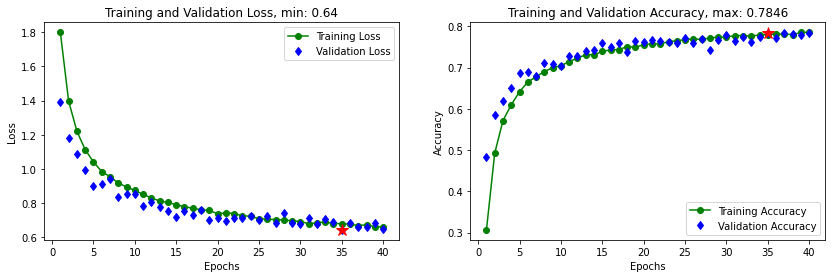

In [ ]:
# More graphs of loss and accuracy
history_dict = hist.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],2)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy') #, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],4)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## More complex model
- CNN: 6 layers
- FCN: 2 layers

> 영상에서 특징을 찾는 CNN은 강화하고, 찾아낸 특징으로 학습하는 FCN은 단순하게 신경망을 구성.

In [23]:
# 모델 구성
num_classes = 10
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=X_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(128, activation='elu'))
model.add(Dense(num_classes, activation='softmax'))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                      

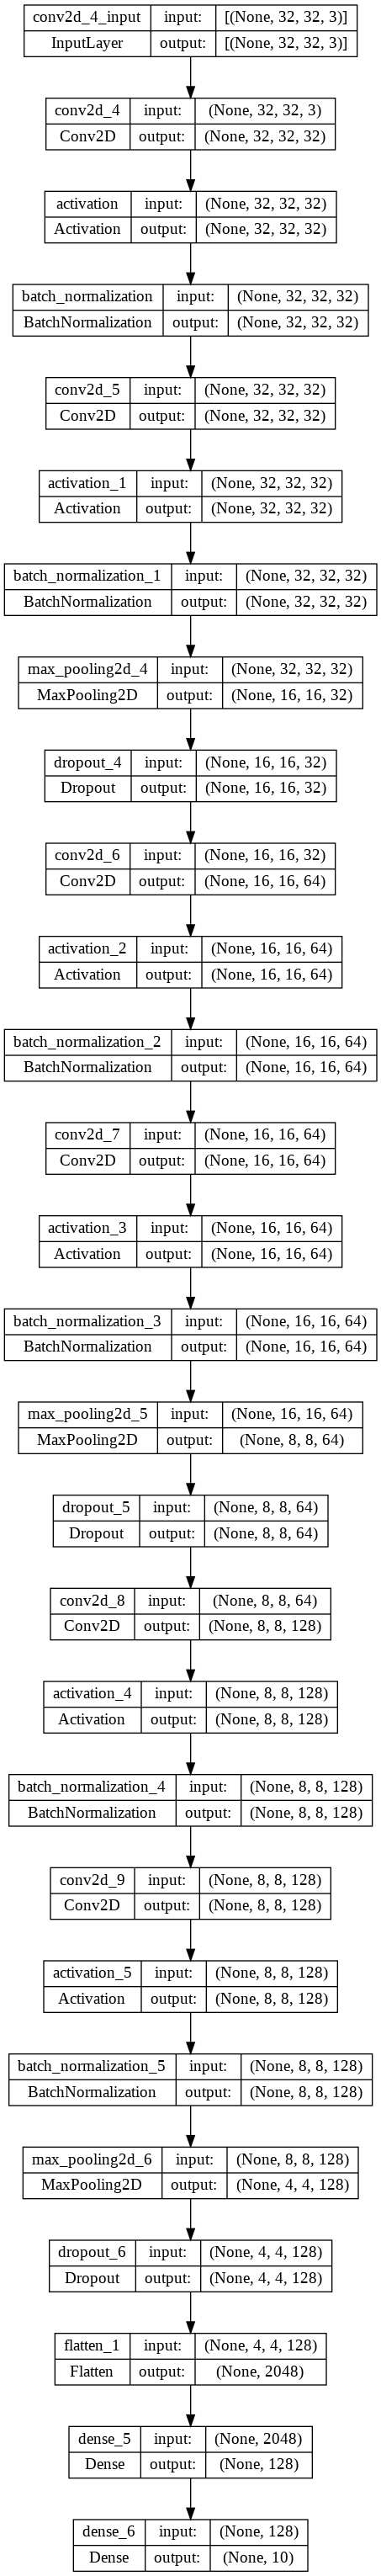

In [24]:
# 모델 구조 요약 - summary(), plot_model()
model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# !pip install visualkeras

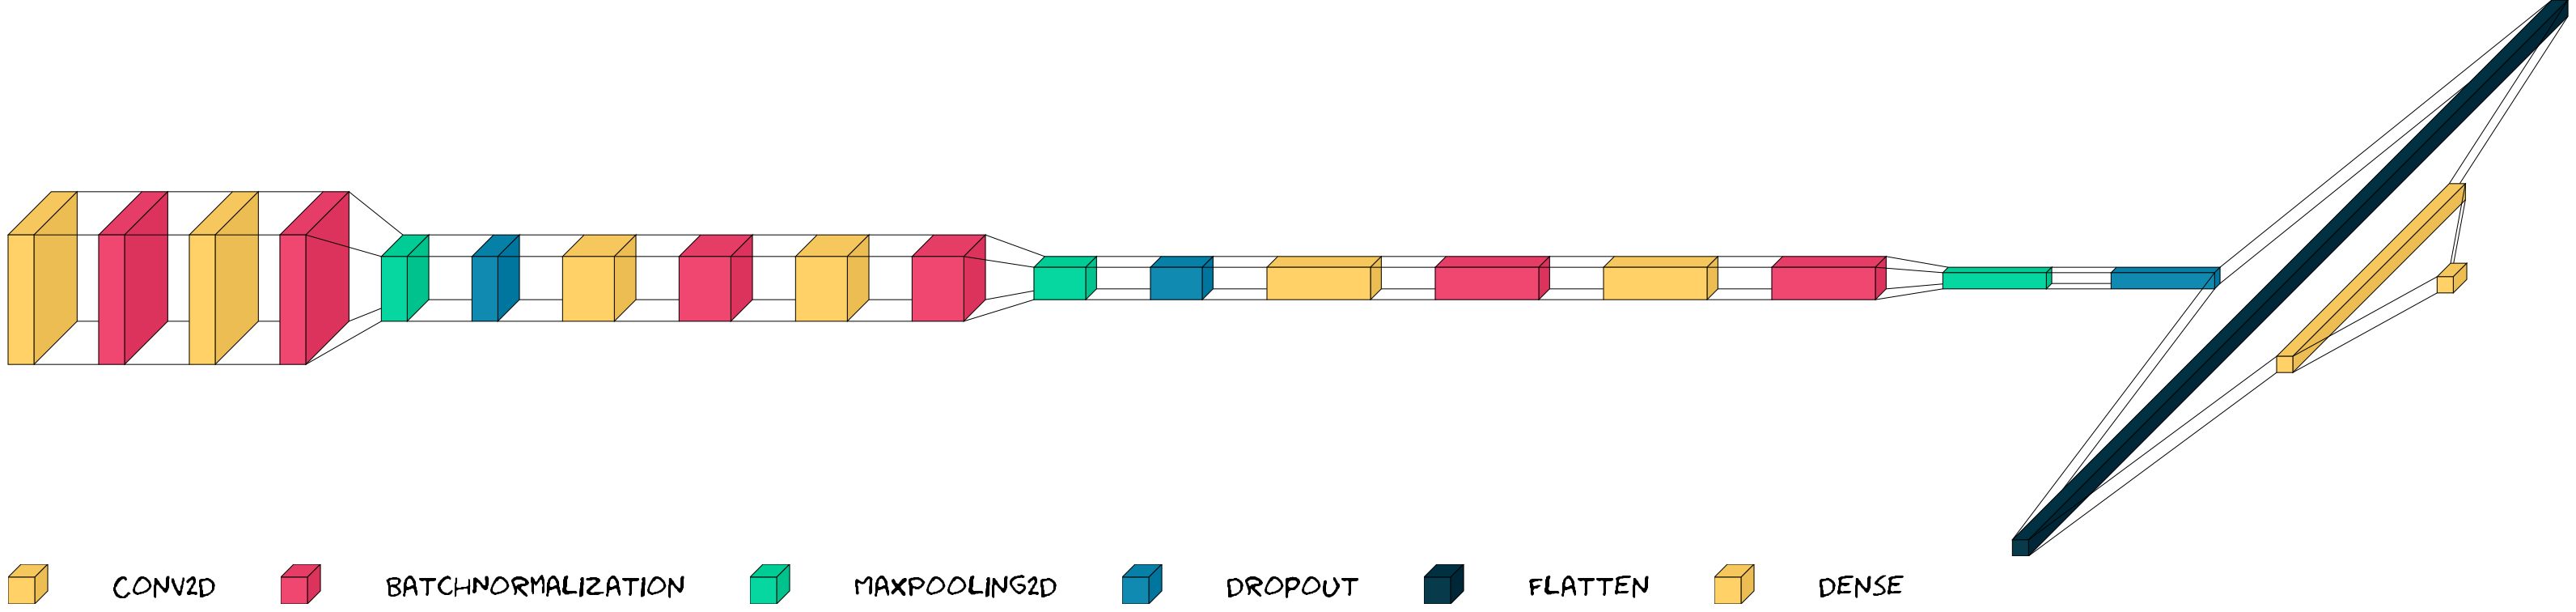

In [26]:
# 모델 구조 시각화 - visualkareas.layered_view()
import visualkeras
from PIL import ImageFont
# font = ImageFont.truetype("arial.ttf", 24) # windows 10/11
font = ImageFont.truetype("Humor-Sans.ttf", 36)  # Linux
visualkeras.layered_view(model, 
                         to_file='./c6f2_daug.png', 
                         legend=True, spacing=80, font=font, 
                         type_ignore=[Activation], 
                         scale_xy=5, scale_z=1, one_dim_orientation='x')

In [27]:
opt_rms = keras.optimizers.RMSprop(learning_rate=0.001,decay=1e-6)

In [28]:
cp_callback = callbacks.ModelCheckpoint(filepath="./cifar10_Daug_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)  # 5, 10, 20, 50

In [29]:
model.compile(loss='categorical_crossentropy',
        optimizer=opt_rms, # 'adam'
        metrics=['accuracy'])

In [30]:
epochs = 500
BATCH_SIZE = 50
hist = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE), 
                 steps_per_epoch=X_train.shape[0]//BATCH_SIZE, 
                 epochs=epochs, verbose=1, 
                 callbacks=[cp_callback, es_callback], 
                 validation_data=(X_test,y_test))

Epoch 1/500
1000/1000 [==============================] - 34s 32ms/step - loss: 1.6109 - accuracy: 0.4626 - val_loss: 1.3414 - val_accuracy: 0.5739
Epoch 2/500
1000/1000 [==============================] - 31s 31ms/step - loss: 1.1694 - accuracy: 0.6136 - val_loss: 1.1117 - val_accuracy: 0.6575
Epoch 3/500
1000/1000 [==============================] - 32s 32ms/step - loss: 1.0412 - accuracy: 0.6664 - val_loss: 0.9452 - val_accuracy: 0.7052
Epoch 4/500
1000/1000 [==============================] - 31s 31ms/step - loss: 0.9623 - accuracy: 0.6992 - val_loss: 0.9851 - val_accuracy: 0.7076
Epoch 5/500
1000/1000 [==============================] - 31s 31ms/step - loss: 0.9029 - accuracy: 0.7239 - val_loss: 0.8377 - val_accuracy: 0.7490
Epoch 6/500
1000/1000 [==============================] - 33s 33ms/step - loss: 0.8583 - accuracy: 0.7419 - val_loss: 0.9581 - val_accuracy: 0.7297
Epoch 7/500
1000/1000 [==============================] - 31s 31ms/step - loss: 0.8278 - accuracy: 0.7555 - val_loss: 0

In [31]:
model.evaluate(X_test, y_test, batch_size = BATCH_SIZE)

200/200 [==============================] - 1s 5ms/step - loss: 0.6926 - accuracy: 0.8250


[0.6925786137580872, 0.824999988079071]

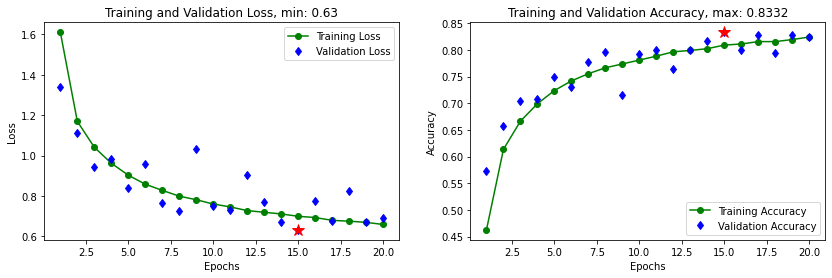

In [32]:
# More graphs of loss and accuracy
history_dict = hist.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],2)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy') #, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],4)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

---

## 모형의 저장

- 트레이닝이 끝난 모형은 save 메서드로 가중치와 함께 hdf5 형식으로 저장
- load 명령으로 불러 사용

### Best Daug model
- cifar10_Daug_best_weights.011-0.8137.hdf5
- cifar10_Daug_best_weights.028-0.8485.hdf5
- cifar10_c4f5_Daug_best_weights.026-0.7891.hdf5
- cifar10_c4f5_Daug_best_weights.035-0.7846.hdf5
- cifar10_Daug_best_weights.015-0.8332.hdf5

### Best c4f5 model of cifar10
- cifar10_c4f5_best_weights.010-0.7446.hdf5
- cifar10_c4f5_best_weights.012-0.7493.hdf5

In [33]:
from keras.models import load_model

model_best = load_model('cifar10_Daug_best_weights.015-0.8332.hdf5')
model_best.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

200/200 [==============================] - 1s 4ms/step - loss: 0.6319 - accuracy: 0.8332


[0.6319399476051331, 0.8331999778747559]

---

In [34]:
from sklearn.metrics import confusion_matrix

predictions = model_best.predict(X_test)
predictions0 = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_test0, predictions0)


313/313 [==============================] - 1s 3ms/step


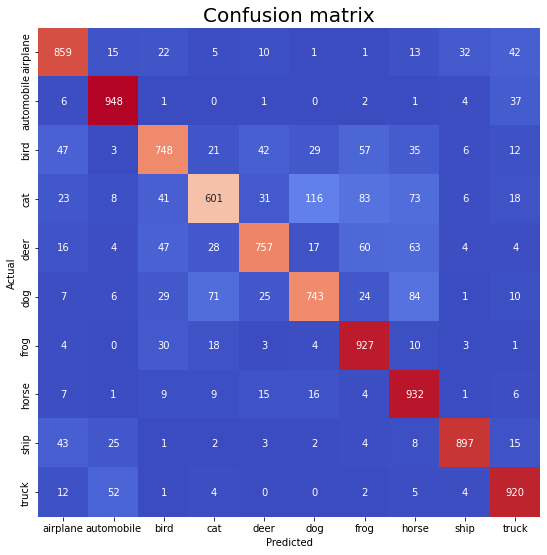

In [35]:
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cm, cbar=False, xticklabels=class_names, yticklabels=class_names, fmt='d', annot=True, cmap=plt.cm.coolwarm)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix', fontsize=20)
plt.show()

## cats and dogs : Not good!

---

# [DIY] Test the best model